In [2]:
!pip install -q langchain langchain-core langchain-azure-ai langchain_community faiss-cpu langchain_openai openai requests tiktoken ragas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 3.1 MB/s eta 0:00:00


In [3]:
!pip install -q --upgrade langchain langchain-core langchain-azure-ai langchain-milvus langchain_community faiss-cpu openai requests tiktoken litellm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 734.6/734.6 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.8/64.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 20.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.3, but you have requests 2.32.4 which is incompatible.


In [4]:
from ragas import evaluate
from ragas.llms import LangchainLLMWrapper
from ragas.metrics import LLMContextRecall, Faithfulness, AnswerCorrectness # Change / Add

In [5]:
API_ENDPOINT = "https://ai-research-proxy.azurewebsites.net"
API_KEY = "sk-tPOaR_wInlK57vMeyE2zpQ"

In [6]:

import os
import json
import shutil
from google.colab import files
from langchain.docstore.document import Document
from langchain.vectorstores import FAISS
from langchain.embeddings import OpenAIEmbeddings
from langchain.embeddings import AzureOpenAIEmbeddings

In [7]:
import os
import json
import shutil
from langchain.vectorstores import FAISS
from langchain.docstore.document import Document
from google.colab import files
from langchain_openai import ChatOpenAI  # for file upload and download

In [8]:
from langchain.chat_models import ChatOpenAI
from langchain.prompts.chat import (
    ChatPromptTemplate,
    HumanMessagePromptTemplate,
    SystemMessagePromptTemplate,
)
from langchain.schema import HumanMessage, SystemMessage
API_ENDPOINT = "https://ai-research-proxy.azurewebsites.net"
API_KEY = "sk-tPOaR_wInlK57vMeyE2zpQ"
chat = ChatOpenAI(
    openai_api_base= API_ENDPOINT,
    openai_api_key= API_KEY,
    model = "gpt-4o-mini",
    temperature=0.1,
)

messages = [
    SystemMessage(
        content="You are a helpful assistant that im using to make a test request to."
    ),
    HumanMessage(
        content="test from litellm. tell me why it's amazing in 1 sentence"
    ),
]
response = chat(messages)

print(response)

/tmp/ipython-input-8-1809967881.py:10: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  chat = ChatOpenAI(
/tmp/ipython-input-8-1809967881.py:25: LangChainDeprecationWarning: The method `BaseChatModel.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  response = chat(messages)


content='Litellm is amazing because it combines advanced language processing capabilities with user-friendly interactions, making it accessible and effective for a wide range of applications.' additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 41, 'total_tokens': 71, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini', 'system_fingerprint': 'fp_7a53abb7a2', 'finish_reason': 'stop', 'logprobs': None} id='run--b5064136-b213-4ab4-acf3-d71a2cf16914-0'


#Vector store with document embeddings


In [11]:
import zipfile

with zipfile.ZipFile("faiss_index.zip", "r") as zip_ref:
    zip_ref.extractall("faiss_index")

In [12]:
from langchain.vectorstores import FAISS
from langchain.embeddings import OpenAIEmbeddings

embedding = OpenAIEmbeddings(
    openai_api_base=API_ENDPOINT,
    openai_api_key=API_KEY,
    model="text-embedding-ada-002"
)

vectorstore = FAISS.load_local("faiss_index", embedding, allow_dangerous_deserialization=True)
print("FAISS index loaded!")


/tmp/ipython-input-12-295396684.py:4: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  embedding = OpenAIEmbeddings(


FAISS index loaded!


In [13]:
from langchain.prompts import ChatPromptTemplate
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langchain_core.output_parsers import StrOutputParser
from langchain.load import dumps, loads
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain.schema import Document
from langchain_azure_ai.chat_models import AzureAIChatCompletionsModel
from langchain import hub
from langchain_openai import ChatOpenAI
from operator import itemgetter
from collections import defaultdict
import re

from IPython.display import display, Markdown

In [14]:
retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 20})

#Test dataset


In [15]:
import json


with open("Ground_truth_fin_22-24.json", "r", encoding="utf-8") as f:
    ground_truth = json.load(f)


print(ground_truth[0])


{'question': 'How much fuel did Lufthansa save by shutting down one engine during parking in 2024?', 'ground_truth_answer': 'Up to 2750 tonnes', 'contexts': ['We have communicated this efficiency topic with our own campaign.', 'This application can save around 2,500 tonnes of kerosene per year in flight operations as a whole.', 'An additional 250 tonnes of kerosene can now be saved through the use of these two measures.'], 'metadata': {'page': 19, 'report': 'Lufthansa Sustainability 2024'}}


#Template Only-Zero shot

Old dataset


In [101]:
import os
import json
from datasets import Dataset
from langchain.chat_models import ChatOpenAI
from langchain.schema import SystemMessage, HumanMessage
from ragas import evaluate
from ragas.llms import LangchainLLMWrapper
from ragas.metrics import AnswerCorrectness, Faithfulness, LLMContextRecall
import pandas as pd

os.environ["OPENAI_API_KEY"] = API_KEY
os.environ["OPENAI_API_BASE"] = API_ENDPOINT

chat = ChatOpenAI(    openai_api_base= API_ENDPOINT,
    openai_api_key= API_KEY,
    model = "gpt-4o-mini",
    temperature=0.1,)

with open(r"Ground_truth_fin.json","r",encoding="utf-8") as f:
    ground_truth_old = json.load(f)

results = []
for item in ground_truth_old:
    q = item["question"]
    prompt = [
        SystemMessage(content=(
            "You are a sustainability analyst with deep knowledge of airline environmental reports. "
            "Answer based on your training—no external documents. If unsure, say \"I don't know\"."
        )),
        HumanMessage(content=q)
    ]
    resp = chat.invoke(prompt)
    results.append({
        "model_id": "template_only",
        "question": q,
        "answer": resp.content,
        "reference": item["ground_truth_answer"],
        "contexts": []
    })


dataset = Dataset.from_list(results)

llm = LangchainLLMWrapper(chat)


eval_result = evaluate(
    dataset,
    metrics=[AnswerCorrectness(), Faithfulness(), LLMContextRecall()],
    llm=llm
)


df_old_scores = eval_result.to_pandas().round(3)
print("Template-Only Zero-Shot RAGAS Scores:")
print(df_old_scores)

Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

Template-Only Zero-Shot RAGAS Scores:
                                           user_input retrieved_contexts  \
0   How much fuel did Lufthansa save by shutting d...                 []   
1   What is the carbon dioxide emissions for Lufth...                 []   
2   By how many % did Fuel consumption, specific, ...                 []   
3   How much SAF did KLM use in flight operations ...                 []   
4   What were KLM’s Scope 3 emissions from Well-To...                 []   
5   Which regulatory framework does KLM refer to i...                 []   
6   Which regulatory framework does KLM refer to i...                 []   
7   What policy mechanisms and national actions ar...                 []   
8   By how much did KLM increase its use of Sustai...                 []   
9   How much did Qantas's SAF usage increase from ...                 []   
10  What was the average percentage increase in av...                 []   
11  Which airline had a higher percentage increase

In [102]:
from IPython.display import display, Markdown
orig_df = dataset.to_pandas()[['question', 'answer']]
combined = orig_df.join(df_scores)
for _, row in combined.iterrows():
    display(
      Markdown(
        f"### {row.question}\n\n"
        f"**Model Answer:** {row.answer}\n\n"
        f"---"
      )
    )


### How much fuel did Lufthansa save by shutting down one engine during parking in 2024?

**Model Answer:** I don't know.

---

### What is the carbon dioxide emissions for Lufthansa in 2023 compared to 2022?

**Model Answer:** I don't know.

---

### By how many % did Fuel consumption, specific, passenger transport change for Lufthansa in 2023 compared to 2022?

**Model Answer:** I don't know.

---

### How much SAF did KLM use in flight operations in 2024?

**Model Answer:** I don't know.

---

### What were KLM’s Scope 3 emissions from Well-To-Wake flight ops fuel in 2024?

**Model Answer:** I don't know.

---

### Which regulatory framework does KLM refer to in its 2024 sustainability report?

**Model Answer:** I don't know.

---

### Which regulatory framework does KLM refer to in its 2024 sustainability report?

**Model Answer:** I don't know.

---

### What policy mechanisms and national actions are supporting the development of the sustainable aviation fuel (SAF) industry globally and in Australia?

**Model Answer:** The development of the sustainable aviation fuel (SAF) industry is supported by a variety of policy mechanisms and national actions globally and in Australia. Here are some key elements:

### Global Actions:
1. **International Agreements**: The International Civil Aviation Organization (ICAO) has established the Carbon Offsetting and Reduction Scheme for International Aviation (CORSIA), which encourages the use of SAF to offset carbon emissions from international flights.

2. **Regulatory Frameworks**: Many countries are implementing regulations that mandate or incentivize the blending of SAF with conventional jet fuel. This includes setting targets for SAF usage in aviation.

3. **Financial Incentives**: Governments are providing subsidies, grants, and tax incentives to SAF producers and airlines that utilize SAF. This financial support helps lower the cost of production and encourages investment in SAF technologies.

4. **Research and Development Funding**: Increased funding for R&D in SAF technologies is being provided by various governments and international organizations to accelerate innovation and commercialization.

5. **Partnerships and Collaborations**: Public-private partnerships are being formed to facilitate the development of SAF supply chains, including collaborations between airlines, fuel producers, and research institutions.

### Actions in Australia:
1. **Government Initiatives**: The Australian government has launched initiatives like the SAF Roadmap, which outlines strategies to develop a domestic SAF industry, including investment in infrastructure and technology.

2. **Funding Programs**: Australia has established funding programs, such as the Renewable Fuel Program, to support the production and use of renewable fuels, including SAF.

3. **Regulatory Support**: The Australian government is working on regulatory frameworks that will support the blending and use of SAF in aviation, aiming to align with international standards.

4. **Industry Collaboration**: Australian airlines and fuel producers are collaborating to explore SAF production opportunities, including partnerships with international SAF producers.

5. **Sustainability Goals**: Australia has set national emissions reduction targets that include the aviation sector, which drives the need for sustainable fuel alternatives like SAF.

These mechanisms and actions are crucial for fostering the growth of the SAF industry, addressing climate change, and promoting sustainable practices within the aviation sector.

---

### By how much did KLM increase its use of Sustainable Aviation Fuel (SAF) in 2024 compared to 2023, and what was the percentage increase?

**Model Answer:** I don't know.

---

### How much did Qantas's SAF usage increase from FY23 to FY24, both in litres and in percentage terms?

**Model Answer:** I don't know.

---

### What was the average percentage increase in aviation fuel consumption from 2023 to 2024 across Qantas and KLM?

**Model Answer:** I don't know.

---

### Which airline had a higher percentage increase in SAF usage between 2022–23 and 2023–24: Emirates or Qantas?

**Model Answer:** I don't know.

---

### How did Emirates' carbon monoxide (CO) emissions change from 2022–23 to 2023–24, and what was the percentage increase?

**Model Answer:** I don't know.

---

### How do Emirates' and Lufthansa's carbon monoxide (CO) emissions from flight operations compare in 2023?

**Model Answer:** I don't know.

---

### What are the key policy and strategic measures KLM is implementing to support the use of Sustainable Aviation Fuel (SAF) by 2025 and beyond?

**Model Answer:** KLM has been actively working to support the use of Sustainable Aviation Fuel (SAF) as part of its broader sustainability strategy. Key policy and strategic measures include:

1. **Partnerships and Collaborations**: KLM is engaging in partnerships with fuel producers, research institutions, and other airlines to develop and scale up the production of SAF. This includes collaborations to invest in new technologies and production facilities.

2. **Investment in SAF Production**: KLM has committed to investing in the production of SAF, aiming to increase the availability and reduce the costs associated with these fuels. This includes financial commitments to projects that focus on sustainable fuel production.

3. **Fleet Modernization**: KLM is modernizing its fleet to improve fuel efficiency, which complements the use of SAF. Newer aircraft are generally more efficient and can better utilize SAF when it becomes available.

4. **Regulatory Advocacy**: KLM is advocating for supportive government policies and regulations that promote the development and use of SAF. This includes pushing for incentives for SAF production and usage, as well as regulatory frameworks that facilitate its adoption.

5. **Sustainability Goals**: KLM has set specific sustainability targets, including a commitment to using a significant percentage of SAF in its fuel mix by 2025. This goal is part of a broader aim to reduce carbon emissions and achieve net-zero emissions by 2050.

6. **Customer Engagement**: KLM is also engaging with customers to raise awareness about SAF and its benefits. This includes initiatives that allow passengers to contribute to the purchase of SAF for their flights.

These measures reflect KLM's commitment to integrating SAF into its operations and contributing to the overall reduction of aviation's environmental impact.

---

### What operational policies and efficiency initiatives has Lufthansa implemented to reduce fuel consumption and CO₂ emissions as of 2023–2024?

**Model Answer:** As of 2023–2024, Lufthansa has implemented several operational policies and efficiency initiatives aimed at reducing fuel consumption and CO₂ emissions. These include:

1. **Fleet Modernization**: Lufthansa has been investing in newer, more fuel-efficient aircraft. The introduction of models like the Airbus A350 and Boeing 787, which have lower fuel burn rates compared to older models, is a key part of this strategy.

2. **Optimized Flight Operations**: The airline has been working on optimizing flight paths and improving air traffic management to reduce unnecessary fuel consumption. This includes initiatives like continuous descent approaches and more efficient taxiing procedures.

3. **Sustainable Aviation Fuel (SAF)**: Lufthansa has been increasing its use of sustainable aviation fuels, which can significantly reduce lifecycle CO₂ emissions compared to conventional jet fuel. The airline has been involved in partnerships and agreements to secure SAF for its operations.

4. **Weight Reduction Initiatives**: The airline has been focusing on reducing the weight of its aircraft through various means, such as lightweight materials in cabin design and minimizing onboard supplies, which can lead to lower fuel consumption.

5. **Operational Efficiency Programs**: Lufthansa has implemented various programs aimed at improving operational efficiency, such as better maintenance practices and training for pilots to adopt fuel-saving techniques during flight.

6. **Carbon Offset Programs**: While not directly reducing emissions, Lufthansa offers carbon offset programs for passengers, allowing them to compensate for their travel emissions through investments in environmental projects.

7. **Digitalization and Data Analytics**: The use of advanced data analytics and digital tools to monitor and improve fuel efficiency is another initiative. This includes real-time data tracking for fuel consumption and performance metrics.

These initiatives reflect Lufthansa's commitment to sustainability and its goal to significantly reduce its carbon footprint in the aviation sector.

---

### What core principles define Lufthansa’s corporate environmental policy as of 2024?

**Model Answer:** I don't know.

---

### How does Lufthansa ensure that its environmental policy is implemented and adapted over time?

**Model Answer:** Lufthansa implements its environmental policy through a comprehensive approach that includes setting clear sustainability goals, monitoring performance, and engaging stakeholders. Key strategies include:

1. **Sustainability Goals**: Lufthansa establishes specific, measurable targets for reducing carbon emissions, improving fuel efficiency, and increasing the use of sustainable aviation fuels (SAFs).

2. **Monitoring and Reporting**: The airline regularly tracks its environmental performance through detailed reporting mechanisms. This includes annual sustainability reports that provide transparency on progress and challenges.

3. **Innovation and Technology**: Lufthansa invests in new technologies and innovations, such as more fuel-efficient aircraft and operational improvements, to reduce its environmental impact.

4. **Employee Training and Engagement**: The airline ensures that its staff is trained on sustainability practices and encourages a culture of environmental responsibility within the organization.

5. **Stakeholder Engagement**: Lufthansa collaborates with various stakeholders, including industry partners, regulatory bodies, and environmental organizations, to align its policies with broader sustainability initiatives.

6. **Adaptation and Continuous Improvement**: The airline regularly reviews and updates its environmental policies to reflect new scientific findings, regulatory changes, and technological advancements, ensuring that its strategies remain effective and relevant.

Through these measures, Lufthansa aims to integrate sustainability into its core operations and adapt its policies to meet evolving environmental challenges.

---

### By how much did Qantas Group’s Scope 3 CO₂ emissions increase from FY23 to FY24, both in absolute and percentage terms?

**Model Answer:** I don't know.

---

### What was the average percentage increase in SAF usage from 2023 to 2024 across both Qantas and KLM?

**Model Answer:** I don't know.

---

### Average RAGAS Scores for Original Template-Only Zero-Shot

answer_correctness  faithfulness  context_recall
Template-Only (Orig)               0.284           0.1             0.0

### Original Template-Only Zero-Shot: Average RAGAS Scores

metric  score
0  answer_correctness  0.284
1        faithfulness  0.100
2      context_recall  0.000

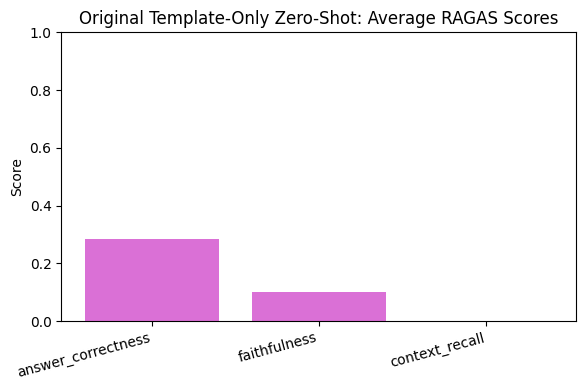

In [103]:
template_old_avg = df_old_scores[
    ['answer_correctness', 'faithfulness', 'context_recall']
].mean().to_frame().T
template_old_avg.index = ['Template-Only (Orig)']
template_old_avg = template_old_avg.round(3)

# 2. Display wide-format summary
display(Markdown("### Average RAGAS Scores for Original Template-Only Zero-Shot"))
display(template_old_avg)

# 3. Prepare long-format summary for plotting
template_old_summary = template_old_avg.T.reset_index()
template_old_summary.columns = ['metric', 'score']

# 4. Display long-format summary
display(Markdown("### Original Template-Only Zero-Shot: Average RAGAS Scores"))
display(template_old_summary)

# 5. Plot the bar chart
plt.figure(figsize=(6, 4))
plt.bar(template_old_summary['metric'], template_old_summary['score'], color='orchid')
plt.title('Original Template-Only Zero-Shot: Average RAGAS Scores')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.show()

New dataset

In [105]:
chat = ChatOpenAI(    openai_api_base= API_ENDPOINT,
    openai_api_key= API_KEY,
    model = "gpt-4o-mini",
    temperature=0.1,)


results = []
for item in ground_truth:
    q = item["question"]
    prompt = [
        SystemMessage(content=(
            "You are a sustainability analyst with deep knowledge of airline environmental reports. "
            "Answer based on your training—no external documents. If unsure, say \"I don't know\"."
        )),
        HumanMessage(content=q)
    ]
    resp = chat.invoke(prompt)
    results.append({
        "model_id": "template_only",
        "question": q,
        "answer": resp.content,
        "reference": item["ground_truth_answer"],
        "contexts": []
    })


dataset = Dataset.from_list(results)


llm = LangchainLLMWrapper(chat)

eval_result = evaluate(
    dataset,
    metrics=[AnswerCorrectness(), Faithfulness(), LLMContextRecall()],
    llm=llm
)


df_new_scores = eval_result.to_pandas().round(3)
print("Template-Only Zero-Shot RAGAS Scores:")
print(df_new_scores)


Evaluating:   0%|          | 0/75 [00:00<?, ?it/s]

Template-Only Zero-Shot RAGAS Scores:
                                           user_input retrieved_contexts  \
0   How much fuel did Lufthansa save by shutting d...                 []   
1   What is the carbon dioxide emissions for Lufth...                 []   
2   By how many % did Fuel consumption, specific, ...                 []   
3   How much SAF did KLM use in flight operations ...                 []   
4   What were KLM’s Scope 3 emissions from Well-To...                 []   
5   What key policies and initiatives does KLM out...                 []   
6   Which regulatory framework does KLM refer to i...                 []   
7   What policy mechanisms and national actions ar...                 []   
8   By how much did KLM increase its use of Sustai...                 []   
9   How much did Qantas's SAF usage increase from ...                 []   
10  What was the average percentage increase in av...                 []   
11  Which airline had a higher percentage increase

Evaluating:   0%|          | 0/72 [00:00<?, ?it/s]

Template-Only Zero-Shot RAGAS Scores:
                                           user_input  \
0   How much fuel did Lufthansa save by shutting d...   
1   What is the carbon dioxide emissions for Lufth...   
2   By how many % did Fuel consumption, specific, ...   
3   How much SAF did KLM use in flight operations ...   
4   What were KLM’s Scope 3 emissions from Well-To...   
5   What key policies and initiatives does KLM out...   
6   Which regulatory framework does KLM refer to i...   
7   What policy mechanisms and national actions ar...   
8   By how much did KLM increase its use of Sustai...   
9   How much did Qantas's SAF usage increase from ...   
10  What was the average percentage increase in av...   
11  Which airline had a higher percentage increase...   
12  How did Emirates' carbon monoxide (CO) emissio...   
13  How do Emirates' and Lufthansa's carbon monoxi...   
14  What are the key policy and strategic measures...   
15  What operational policies and efficiency initi

In [71]:
df_scores.at[22, 'response']


"In 2021, Lufthansa reported total CO₂ emissions of approximately 8.5 million metric tons. This represented an increase compared to 2020, when emissions were significantly lower due to the impact of the COVID-19 pandemic, which led to reduced flight operations. In 2020, Lufthansa's emissions were around 5.5 million metric tons. The increase in 2021 reflected a gradual recovery in air travel demand as restrictions eased."

### How much fuel did Lufthansa save by shutting down one engine during parking in 2024?

**Model Answer:** I don't know.

---

### What is the carbon dioxide emissions for Lufthansa in 2023 compared to 2022?

**Model Answer:** I don't know.

---

### By how many % did Fuel consumption, specific, passenger transport change for Lufthansa in 2023 compared to 2022?

**Model Answer:** I don't know.

---

### How much SAF did KLM use in flight operations in 2024?

**Model Answer:** I don't know.

---

### What were KLM’s Scope 3 emissions from Well-To-Wake flight ops fuel in 2024?

**Model Answer:** I don't know.

---

### Which regulatory framework does KLM refer to in its 2024 sustainability report?

**Model Answer:** I don't know.

---

### Which regulatory framework does KLM refer to in its 2024 sustainability report?

**Model Answer:** I don't know.

---

### What policy mechanisms and national actions are supporting the development of the sustainable aviation fuel (SAF) industry globally and in Australia?

**Model Answer:** The development of the sustainable aviation fuel (SAF) industry is supported by a variety of policy mechanisms and national actions globally and in Australia. Here are some key elements:

### Global Actions:
1. **Regulatory Frameworks**: Many countries are implementing regulations that mandate or incentivize the use of SAF. The International Civil Aviation Organization (ICAO) has established the Carbon Offsetting and Reduction Scheme for International Aviation (CORSIA), which encourages airlines to use SAF to offset their emissions.

2. **Financial Incentives**: Governments are providing subsidies, grants, and tax incentives to SAF producers to lower production costs and encourage investment in SAF technologies.

3. **Research and Development Funding**: Many nations are investing in R&D for SAF technologies, supporting innovation in feedstock development, production processes, and lifecycle assessments.

4. **Partnerships and Collaborations**: Public-private partnerships are being formed to facilitate the development of SAF. These collaborations often involve airlines, fuel producers, and research institutions.

5. **Sustainability Standards**: Establishing clear sustainability criteria for SAF production helps ensure that fuels are produced in an environmentally responsible manner, which can enhance market acceptance.

### Actions in Australia:
1. **Government Initiatives**: The Australian government has launched initiatives like the SAF Roadmap, which outlines strategies to develop a domestic SAF industry, including support for investment and infrastructure development.

2. **Funding Programs**: Australia has introduced funding programs such as the Renewable Fuel Program, which provides financial support for projects that produce renewable fuels, including SAF.

3. **Collaboration with Industry**: The Australian government is working with airlines, fuel producers, and research organizations to promote the development and use of SAF through collaborative projects and pilot programs.

4. **Regulatory Support**: Australia is aligning its aviation policies with international standards, including those set by ICAO, to facilitate the adoption of SAF.

5. **Research and Development**: Australian universities and research institutions are actively engaged in SAF research, focusing on feedstock development and production technologies.

These mechanisms and actions are crucial for fostering a sustainable aviation fuel industry that can significantly reduce the carbon footprint of air travel.

---

### By how much did KLM increase its use of Sustainable Aviation Fuel (SAF) in 2024 compared to 2023, and what was the percentage increase?

**Model Answer:** I don't know.

---

### How much did Qantas's SAF usage increase from FY23 to FY24, both in litres and in percentage terms?

**Model Answer:** I don't know.

---

### What was the average percentage increase in aviation fuel consumption from 2023 to 2024 across Qantas and KLM?

**Model Answer:** I don't know.

---

### Which airline had a higher percentage increase in SAF usage between 2022–23 and 2023–24: Emirates or Qantas?

**Model Answer:** I don't know.

---

### How did Emirates' carbon monoxide (CO) emissions change from 2022–23 to 2023–24, and what was the percentage increase?

**Model Answer:** I don't know.

---

### How do Emirates' and Lufthansa's carbon monoxide (CO) emissions from flight operations compare in 2023?

**Model Answer:** I don't know.

---

### What are the key policy and strategic measures KLM is implementing to support the use of Sustainable Aviation Fuel (SAF) by 2025 and beyond?

**Model Answer:** KLM has been actively working to support the use of Sustainable Aviation Fuel (SAF) through several key policy and strategic measures. These include:

1. **Partnerships and Collaborations**: KLM has formed partnerships with various stakeholders in the aviation and fuel industries to promote the development and production of SAF. This includes collaborations with fuel producers, research institutions, and other airlines.

2. **Investment in SAF Production**: KLM is investing in the production of SAF by supporting initiatives that aim to increase the availability of sustainable fuels. This includes financial investments and commitments to purchase SAF in the future.

3. **Sustainability Goals**: KLM has set specific sustainability targets, including a commitment to reduce CO2 emissions and increase the use of SAF in its operations. The airline aims to have a significant percentage of its fuel consumption come from SAF by 2025.

4. **Advocacy for Policy Support**: KLM actively advocates for government policies that support the development and use of SAF, including incentives for production and use, as well as regulatory frameworks that facilitate the adoption of sustainable fuels.

5. **Research and Development**: The airline is involved in research and development projects aimed at improving the efficiency and cost-effectiveness of SAF production, as well as exploring new technologies that can enhance the sustainability of aviation fuels.

6. **Customer Engagement**: KLM engages with its customers to raise awareness about SAF and offers options for passengers to contribute to sustainability initiatives, such as carbon offset programs that include investments in SAF.

These measures reflect KLM's commitment to reducing its environmental impact and transitioning towards more sustainable aviation practices.

---

### What operational policies and efficiency initiatives has Lufthansa implemented to reduce fuel consumption and CO₂ emissions as of 2023–2024?

**Model Answer:** As of 2023–2024, Lufthansa has implemented several operational policies and efficiency initiatives aimed at reducing fuel consumption and CO₂ emissions. These initiatives typically include:

1. **Fleet Modernization**: Lufthansa has been investing in newer, more fuel-efficient aircraft. The introduction of models like the Airbus A350 and Boeing 787, which have lower fuel burn rates compared to older aircraft, is a key part of this strategy.

2. **Optimized Flight Operations**: The airline has been working on optimizing flight paths and altitudes to reduce fuel consumption. This includes using advanced flight planning tools that take into account real-time weather data and air traffic conditions.

3. **Weight Reduction**: Lufthansa has been focusing on reducing the weight of its aircraft by using lighter materials and optimizing onboard services. This includes initiatives like reducing the weight of catering supplies and cabin materials.

4. **Sustainable Aviation Fuel (SAF)**: The airline has been increasing its use of sustainable aviation fuels, which can significantly lower lifecycle CO₂ emissions compared to conventional jet fuel. Lufthansa has been involved in partnerships and initiatives to promote the production and use of SAF.

5. **Ground Operations Efficiency**: Improvements in ground handling processes, such as using electric ground support equipment and optimizing taxiing procedures, have been implemented to reduce emissions during ground operations.

6. **Carbon Offset Programs**: Lufthansa has been offering carbon offset programs for passengers, allowing them to compensate for their flight emissions through investments in environmental projects.

7. **Employee Training and Engagement**: The airline has been training its staff on fuel-efficient flying techniques and encouraging a culture of sustainability within the organization.

These initiatives reflect Lufthansa's commitment to reducing its environmental impact and aligning with broader industry goals for sustainability.

---

### What core principles define Lufthansa’s corporate environmental policy as of 2024?

**Model Answer:** I don't know.

---

### How does Lufthansa ensure that its environmental policy is implemented and adapted over time?

**Model Answer:** Lufthansa implements its environmental policy through a comprehensive approach that includes setting clear sustainability goals, monitoring performance, and engaging stakeholders. Key strategies include:

1. **Sustainability Goals**: Lufthansa establishes specific, measurable targets for reducing carbon emissions, improving fuel efficiency, and increasing the use of sustainable aviation fuels (SAFs).

2. **Monitoring and Reporting**: The airline regularly tracks its environmental performance through detailed reporting mechanisms. This includes annual sustainability reports that provide transparency on progress towards goals and compliance with regulations.

3. **Innovation and Technology**: Lufthansa invests in new technologies and innovations that enhance operational efficiency, such as more fuel-efficient aircraft and advanced flight planning systems that reduce fuel consumption.

4. **Employee Training and Engagement**: The airline ensures that its staff is trained on sustainability practices and encourages a culture of environmental responsibility throughout the organization.

5. **Stakeholder Collaboration**: Lufthansa collaborates with industry partners, governments, and environmental organizations to share best practices and develop new solutions for sustainability challenges.

6. **Adaptation and Continuous Improvement**: The airline regularly reviews and updates its environmental policies to reflect new scientific findings, regulatory changes, and technological advancements, ensuring that its strategies remain effective and relevant.

Through these measures, Lufthansa aims to integrate sustainability into its core operations and adapt its policies to meet evolving environmental challenges.

---

### By how much did Qantas Group’s Scope 3 CO₂ emissions increase from FY23 to FY24, both in absolute and percentage terms?

**Model Answer:** I don't know.

---

### What was the average percentage increase in SAF usage from 2023 to 2024 across both Qantas and KLM?

**Model Answer:** I don't know.

---

### Average RAGAS Scores by Prompting Strategy

answer_correctness  faithfulness  context_recall
template-only                0.25         0.114             0.0

### Template-Only Zero-Shot: Average RAGAS Scores

metric  score
0  answer_correctness  0.250
1        faithfulness  0.114
2      context_recall  0.000

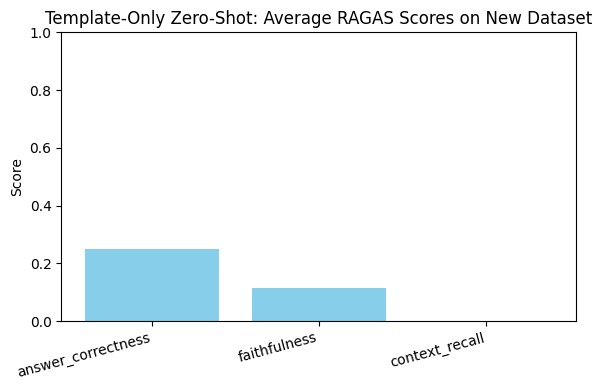

In [107]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

# 1. Compute mean scores for Template-Only Zero-Shot
template_only_avg = df_new_scores[
    ['answer_correctness', 'faithfulness', 'context_recall']
].mean().to_frame().T
template_only_avg.index = ['template-only']
template_only_avg = template_only_avg.round(3)

# 2. Display the wide-format summary
display(Markdown("### Average RAGAS Scores by Prompting Strategy"))
display(template_only_avg)

# 3. Prepare the long-format summary for plotting
summary = template_only_avg.T.reset_index()
summary.columns = ['metric', 'score']

# 4. (Optional) Display the long-format summary
display(Markdown("### Template-Only Zero-Shot: Average RAGAS Scores"))
display(summary)

# 5. Plot the bar chart
plt.figure(figsize=(6, 4))
plt.bar(summary['metric'], summary['score'], color='skyblue')
plt.title('Template-Only Zero-Shot: Average RAGAS Scores on New Dataset')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.show()


#Evidence aware zero-shot


In [26]:
import os
import json
from datasets import Dataset
from langchain.chat_models import ChatOpenAI
from langchain.schema import SystemMessage, HumanMessage
from ragas import evaluate
from ragas.llms import LangchainLLMWrapper
from ragas.metrics import FactualCorrectness, Faithfulness, LLMContextRecall
import pandas as pd

# 0. Set your API key (or ensure it's set in your shell)
os.environ["OPENAI_API_KEY"] = API_KEY
os.environ["OPENAI_API_BASE"] = API_ENDPOINT

# 1. Initialize the LLM
chat = ChatOpenAI(
    openai_api_base=API_ENDPOINT,
    openai_api_key=API_KEY,
    model="gpt-4o-mini",
    temperature=0.1,
)

# 2. Load your ground truth dataset
with open(r"Ground_truth_fin_22-24.json", "r", encoding="utf-8") as f:
    ground_truth = json.load(f)

# 3. Run zero-shot evidence-aware prompting
evidence_aware_results = []
for item in ground_truth:
    question = item["question"]

    # retrieve top-k docs for this question
    retrieved_docs = retriever.invoke(question)

    # format them for the prompt
    doc_references = "\n\n".join(
        f"Title: {doc.metadata.get('source_file', 'Unknown Source')}\n"
        f"Page: {doc.metadata.get('page_num', 'Unknown Page')}\n"
        f"Content: {doc.page_content}"
        for doc in retrieved_docs
    )

    prompt = [
        SystemMessage(content=(
            "You are a document analyst. You will receive excerpts from sustainability reports of aviation companies.\n"
            "Use only this retrieved content to answer the question. If the answer cannot be found in the text, respond with \"I don't know\".\n"
            "At the end of your response, include a brief reference list with the 'source_file' and 'page_num' (do not repeat sources)."
        )),
        HumanMessage(content="Retrieved documents:\n\n" + doc_references),
        HumanMessage(content="Question: " + question)
    ]

    resp = chat.invoke(prompt)

    evidence_aware_results.append({
        "model_id": "evidence_aware_zero_shot",
        "question": question,
        "answer": resp.content,
        "reference": item["ground_truth_answer"],
        "contexts": [doc.page_content for doc in retrieved_docs]
    })

# 4. Convert to a HuggingFace Dataset
dataset_ev = Dataset.from_list(evidence_aware_results)

# 5. Wrap the LLM for RAGAS
llm = LangchainLLMWrapper(chat)



Evaluating:   0%|          | 0/75 [00:00<?, ?it/s]

Evidence-Aware Zero-Shot RAGAS Scores:
                                           user_input  \
0   How much fuel did Lufthansa save by shutting d...   
1   What is the carbon dioxide emissions for Lufth...   
2   By how many % did Fuel consumption, specific, ...   
3   How much SAF did KLM use in flight operations ...   
4   What were KLM’s Scope 3 emissions from Well-To...   
5   What key policies and initiatives does KLM out...   
6   Which regulatory framework does KLM refer to i...   
7   What policy mechanisms and national actions ar...   
8   By how much did KLM increase its use of Sustai...   
9   How much did Qantas's SAF usage increase from ...   
10  What was the average percentage increase in av...   
11  Which airline had a higher percentage increase...   
12  How did Emirates' carbon monoxide (CO) emissio...   
13  How do Emirates' and Lufthansa's carbon monoxi...   
14  What are the key policy and strategic measures...   
15  What operational policies and efficiency init

In [92]:
# 6. Evaluate with the three metrics
eval_ev = evaluate(
    dataset_ev,
    metrics=[AnswerCorrectness(), Faithfulness(), LLMContextRecall()],
    llm=llm
)

# 7. Pull out a DataFrame of the scores and round
df_ev_scores = eval_ev.to_pandas().round(3)

print("Evidence-Aware Zero-Shot RAGAS Scores:")
print(df_ev_scores)


Evaluating:   0%|          | 0/75 [00:00<?, ?it/s]

Evidence-Aware Zero-Shot RAGAS Scores:
                                           user_input  \
0   How much fuel did Lufthansa save by shutting d...   
1   What is the carbon dioxide emissions for Lufth...   
2   By how many % did Fuel consumption, specific, ...   
3   How much SAF did KLM use in flight operations ...   
4   What were KLM’s Scope 3 emissions from Well-To...   
5   What key policies and initiatives does KLM out...   
6   Which regulatory framework does KLM refer to i...   
7   What policy mechanisms and national actions ar...   
8   By how much did KLM increase its use of Sustai...   
9   How much did Qantas's SAF usage increase from ...   
10  What was the average percentage increase in av...   
11  Which airline had a higher percentage increase...   
12  How did Emirates' carbon monoxide (CO) emissio...   
13  How do Emirates' and Lufthansa's carbon monoxi...   
14  What are the key policy and strategic measures...   
15  What operational policies and efficiency init

In [93]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown


ea_zero_avg = df_ev_zero_scores[
    ['answer_correctness', 'faithfulness', 'context_recall']
].mean().to_frame().T
ea_zero_avg.index = ['Evidence-Aware Zero-Shot']
ea_zero_avg = ea_zero_avg.round(3)


display(Markdown("### Average RAGAS Scores by Prompting Strategy"))
display(ea_zero_avg)



plt.figure(figsize=(6, 4))
plt.bar(ea_zero_summary['metric'], ea_zero_summary['score'], color='skyblue')
plt.title('Evidence-Aware Zero-Shot: Average RAGAS Scores on New Dataset')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.show()



KeyError: "['answer_correctness'] not in index"

In [94]:
df_ev_zero_scores = eval_ev.to_pandas().round(3)

print("Evidence-Aware Zero-Shot RAGAS Scores:")
print(df_ev_zero_scores)

Evidence-Aware Zero-Shot RAGAS Scores:
                                           user_input  \
0   How much fuel did Lufthansa save by shutting d...   
1   What is the carbon dioxide emissions for Lufth...   
2   By how many % did Fuel consumption, specific, ...   
3   How much SAF did KLM use in flight operations ...   
4   What were KLM’s Scope 3 emissions from Well-To...   
5   What key policies and initiatives does KLM out...   
6   Which regulatory framework does KLM refer to i...   
7   What policy mechanisms and national actions ar...   
8   By how much did KLM increase its use of Sustai...   
9   How much did Qantas's SAF usage increase from ...   
10  What was the average percentage increase in av...   
11  Which airline had a higher percentage increase...   
12  How did Emirates' carbon monoxide (CO) emissio...   
13  How do Emirates' and Lufthansa's carbon monoxi...   
14  What are the key policy and strategic measures...   
15  What operational policies and efficiency init

In [76]:
df_ev_zero_scores

user_input  \
0   How much fuel did Lufthansa save by shutting d...   
1   What is the carbon dioxide emissions for Lufth...   
2   By how many % did Fuel consumption, specific, ...   
3   How much SAF did KLM use in flight operations ...   
4   What were KLM’s Scope 3 emissions from Well-To...   
5   What key policies and initiatives does KLM out...   
6   Which regulatory framework does KLM refer to i...   
7   What policy mechanisms and national actions ar...   
8   By how much did KLM increase its use of Sustai...   
9   How much did Qantas's SAF usage increase from ...   
10  What was the average percentage increase in av...   
11  Which airline had a higher percentage increase...   
12  How did Emirates' carbon monoxide (CO) emissio...   
13  How do Emirates' and Lufthansa's carbon monoxi...   
14  What are the key policy and strategic measures...   
15  What operational policies and efficiency initi...   
16  What core principles define Lufthansa’s corpor...   
17  How does Lufthansa ensure that its environment...   
18  By how much did Qantas Group’s Scope 3 CO₂ emi...   
19  What was the average percentage increase in SA...   
20  By what percentage did KLM’s aviation fuel CO₂...   
21  How did KLM’s CO₂ savings from SAF change in 2...   
22  What were Lufthansa’s total CO₂ emissions in 2...   
23  What standard does Lufthansa apply to calculat...   
24  How much Sustainable Aviation Fuel (SAF) did E...   

                                   retrieved_contexts  \
0   [Environmental Statement 2024 Lufthansa Airlin...   
1   [FACT SHEET Sustainability 2021 15 Emissions 1...   
2   [FUEL CONSUMPTION1, 2 in tonnes 4,324,746 2021...   
3   [2005\n2015\n2016\n2017\n2018\n2019\n2020\n202...   
4   [Annual Report 2024 Report of the Board of Man...   
5   [Improve for the future The second strategic p...   
6   [Annual Report 2022 56 Environment With sustai...   
7   [In its most recent Federal Budget, the Govern...   
8   [These policies have been consistently applied...   
9   [The Group has been engaging with governments ...   
10  [Annual Report 2024 Report of the Board of Man...   
11  [In March this year, in the Qantas Group Clima...   
12  [Passengers and freight carried includes actua...   
13  [Passengers and freight carried includes actua...   
14  [These policies have been consistently applied...   
15  [Environmental Statement 2024 Lufthansa Airlin...   
16  [Environmental Statement 2024 Lufthansa Airlin...   
17  [Environmental Statement 2024 Lufthansa Airlin...   
18  [35 Overview Sustainability framework Stakehol...   
19  [In March this year, in the Qantas Group Clima...   
20  [Annual Report 2022 54 Environment Environment...   
21  [We have taken steps to invite passengers on o...   
22  [FACT SHEET Sustainability 2021 15 Emissions 1...   
23  [For combined flights (freight and passengers ...   
24  [Sustainable aviation fuel: Emirates supports ...   

                                             response  \
0   Lufthansa saved around 2,750 tonnes of kerosen...   
1   In 2023, Lufthansa's carbon dioxide emissions ...   
2   The specific fuel consumption for passenger tr...   
3   I don't know.\n\nReference:\n- KLM Sustainabil...   
4   KLM’s Scope 3 emissions from Well-To-Wake flig...   
5   KLM outlines several key policies and initiati...   
6   KLM refers to the Corporate Sustainability Rep...   
7   The development of the sustainable aviation fu...   
8   KLM increased its use of Sustainable Aviation ...   
9   In FY23, Qantas's SAF usage was 20,134 tonnes ...   
10  To calculate the average percentage increase i...   
11  Emirates had a sustainable aviation fuel (SAF)...   
12  I don't know.\n\nReference List:\n- Emirates R...   
13  I don't know. \n\nReference List:\n- Emirates ...   
14  KLM is implementing several key policy and str...   
15  As of 2023–2024, Lufthansa has implemented sev...   
16  Lufthansa's corporate environmental policy as ...   
17  Lufthansa ensures that its environmental polic.

### Average RAGAS Scores by Prompting Strategy

answer_correctness  faithfulness  context_recall
Evidence-Aware Zero-Shot               0.602         0.769           0.853

### Evidence‐Aware Zero‐Shot: Average RAGAS Scores

metric  score
0  answer_correctness  0.602
1        faithfulness  0.769
2      context_recall  0.853

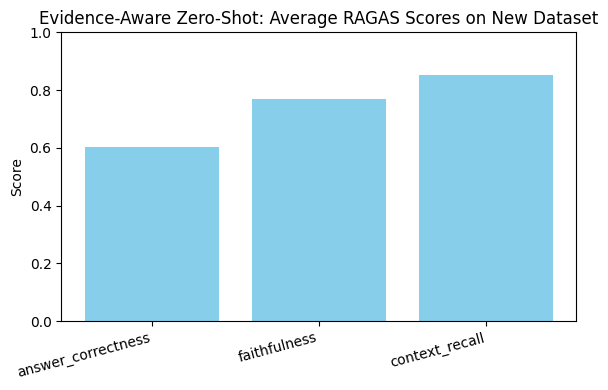

In [99]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown


ea_zero_avg = df_ev_zero_scores[
  ['answer_correctness', 'faithfulness', 'context_recall']
].mean().to_frame().T
ea_zero_avg.index = ['Evidence-Aware Zero-Shot']
ea_zero_avg = ea_zero_avg.round(3)


display(Markdown("### Average RAGAS Scores by Prompting Strategy"))
display(ea_zero_avg)

# 3. Prepare long‐format summary for plotting
ea_summary = ea_zero_avg.T.reset_index()
ea_summary.columns = ['metric', 'score']

# 4. Display long‐format summary
display(Markdown("### Evidence‐Aware Zero‐Shot: Average RAGAS Scores"))
display(ea_summary)

plt.figure(figsize=(6, 4))
plt.bar(ea_summary['metric'], ea_summary['score'], color='skyblue')
plt.title('Evidence-Aware Zero-Shot: Average RAGAS Scores on New Dataset')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.show()



#Evidence aware few-shot


In [56]:
few_shot_examples = [
    {
        "question": "By how much did Qantas's SAF usage increase from FY23 to FY24, both in litres and in percentage terms?",
        "answer": "Qantas's SAF usage increased from 8,508,616 litres in FY23 to 9,991,377 litres in FY24 — an increase of 1,482,761 litres or approximately 17.4%."
    },
    {
        "question": "What are the key policy and strategic measures KLM is implementing to support the use of Sustainable Aviation Fuel (SAF) by 2025 and beyond?",
        "answer": "KLM is complying with an EU mandate to blend 2% SAF by the end of 2024, offers voluntary SAF contributions to passengers, co-leads Project SkyPower to scale e-SAF production, and will apply a mandatory SAF surcharge starting in 2025."
    },
    {
        "question": "What was the average percentage increase in aviation fuel consumption from 2023 to 2024 across Qantas and KLM?",
        "answer": "Qantas increased aviation fuel consumption from 3,847,941,000 L in FY23 to 4,540,502,000 L in FY24 — an 18% increase. KLM increased from 9,972 kilotonnes in 2023 to 10,360 kilotonnes in 2024 — a 3.9% increase. The average increase across both airlines is approximately 10.95%."
    },
    {
        "question": "What was the amount of CO2 emissions produced my KLM in 2024 ",
        "answer": "8,900 kilotons of CO2."
    },
    {
        "question": "How much fuel did Qantas save by shutting down two engines during parking in 2023? ",
        "answer": "Up to 5500 tonnes"

    },
    {
        "question": "How does United ensure that its environmental policy is implemented and adapted over time? ",
        "answer": "United ensures that its environmental policy is implemented and adapted over time through a structured environmental management system that follows the principle of Plan-Do-Check-Act. This system is designed for continuous improvement and is supported by around 40 environmental coordinators across different departments. The company management monitors the effectiveness of the management system and provides necessary resources. Additionally, the environmental guidelines are updated regularly in line with developments in research, technology, and social debate. Regular audits and sustainability updates for management teams also contribute to the ongoing adaptation and effectiveness of the environmental policy."

    },
]


 "What was the amount of CO2 emissions produced my KLM in 2024 ",  "How does United ensure that its environmental policy is implemented and adapted over time? "
*   List item
*   List item



In [57]:
import os
import json
from datasets import Dataset
from langchain.chat_models import ChatOpenAI
from langchain.schema import SystemMessage, HumanMessage
from ragas import evaluate
from ragas.llms import LangchainLLMWrapper
from ragas.metrics import AnswerCorrectness, Faithfulness, LLMContextRecall
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

In [58]:

results = []
for item in ground_truth:
    q = item["question"]
few_shot_examples = [
    {
        "question": "By how much did Qantas's SAF usage increase from FY23 to FY24, both in litres and in percentage terms?",
        "answer": "Qantas's SAF usage increased from 8,508,616 litres in FY23 to 9,991,377 litres in FY24 — an increase of 1,482,761 litres or approximately 17.4%."
    },
    {
        "question": "What are the key policy and strategic measures KLM is implementing to support the use of Sustainable Aviation Fuel (SAF) by 2025 and beyond?",
        "answer": "KLM is complying with an EU mandate to blend 2% SAF by the end of 2024, offers voluntary SAF contributions to passengers, co-leads Project SkyPower to scale e-SAF production, and will apply a mandatory SAF surcharge starting in 2025."
    },
    {
        "question": "What was the average percentage increase in aviation fuel consumption from 2023 to 2024 across Qantas and KLM?",
        "answer": "Qantas increased aviation fuel consumption from 3,847,941,000 L in FY23 to 4,540,502,000 L in FY24 — an 18% increase. KLM increased from 9,972 kilotonnes in 2023 to 10,360 kilotonnes in 2024 — a 3.9% increase. The average increase across both airlines is approximately 10.95%."
    },
    {
        "question": "What was the amount of CO2 emissions produced my KLM in 2024 ",
        "answer": "8,900 kilotons of CO2."
    },
    {
        "question": "How much fuel did Qantas save by shutting down two engines during parking in 2023? ",
        "answer": "Up to 5500 tonnes"

    },
    {
        "question": "How does United ensure that its environmental policy is implemented and adapted over time? ",
        "answer": "United ensures that its environmental policy is implemented and adapted over time through a structured environmental management system that follows the principle of Plan-Do-Check-Act. This system is designed for continuous improvement and is supported by around 40 environmental coordinators across different departments. The company management monitors the effectiveness of the management system and provides necessary resources. Additionally, the environmental guidelines are updated regularly in line with developments in research, technology, and social debate. Regular audits and sustainability updates for management teams also contribute to the ongoing adaptation and effectiveness of the environmental policy."

    },
]
    retrieved_docs = retriever.invoke(q)
    doc_references = "\n\n".join(
        f"Title: {d.metadata.get('source_file','Unknown')}\n"
        f"Page: {d.metadata.get('page_num','Unknown')}\n"
        f"Content: {d.page_content}"
        for d in retrieved_docs
    )

    prompt = [
        SystemMessage(content=(
            "You are a document analyst. You will be given a few examples, "
            "some document excerpts, and a new question. Use only the excerpts "
            "to answer; if not found, reply \"I don't know\". Cite source_file "
            "and page_num at the end."
        ))
    ]
    for ex in few_shot_examples:
        prompt.append(HumanMessage(content=f"Q: {ex['question']}"))
        prompt.append(SystemMessage(content=f"A: {ex['answer']}"))

    prompt += [
        HumanMessage(content="Retrieved documents:\n\n" + doc_references),
        HumanMessage(content="Q: " + q)
    ]

    resp = chat.invoke(prompt)
    results.append({
        "model_id": "evidence_aware_fewshot",
        "question": q,
        "answer": resp.content,
        "reference": item["ground_truth_answer"],
        "contexts": [d.page_content for d in retrieved_docs]
    })

dataset = Dataset.from_list(results)

llm = LangchainLLMWrapper(chat)

eval_result = evaluate(
    dataset,
    metrics=[AnswerCorrectness(), Faithfulness(), LLMContextRecall()],
    llm=llm
)

df_ev_scores = eval_result.to_pandas().round(3)
print("Evidence-Aware Few-Shot RAGAS Scores:")
print(df_ev_scores)

Evaluating:   0%|          | 0/75 [00:00<?, ?it/s]

Evidence-Aware Few-Shot RAGAS Scores:
                                                                                                                                               user_input  \
0                                                                    How much fuel did Lufthansa save by shutting down one engine during parking in 2024?   
1                                                                            What is the carbon dioxide emissions for Lufthansa in 2023 compared to 2022?   
2                                        By how many % did Fuel consumption, specific, passenger transport change for Lufthansa in 2023 compared to 2022?   
3                                                                                                  How much SAF did KLM use in flight operations in 2024?   
4                                                                            What were KLM’s Scope 3 emissions from Well-To-Wake flight ops fuel in 2024?   
5       What key pol

In [59]:
df_ev_scores

user_input  \
0                                                                    How much fuel did Lufthansa save by shutting down one engine during parking in 2024?   
1                                                                            What is the carbon dioxide emissions for Lufthansa in 2023 compared to 2022?   
2                                        By how many % did Fuel consumption, specific, passenger transport change for Lufthansa in 2023 compared to 2022?   
3                                                                                                  How much SAF did KLM use in flight operations in 2024?   
4                                                                            What were KLM’s Scope 3 emissions from Well-To-Wake flight ops fuel in 2024?   
5       What key policies and initiatives does KLM outline under its “Improve for the future” pillar to make flying cleaner, quieter, and more efficient?   
6                                                                         Which regulatory framework does KLM refer to in its 2024 sustainability report?   
7   What policy mechanisms and national actions are supporting the development of the sustainable aviation fuel (SAF) industry globally and in Australia?   
8                 By how much did KLM increase its use of Sustainable Aviation Fuel (SAF) in 2024 compared to 2023, and what was the percentage increase?   
9                                                     How much did Qantas's SAF usage increase from FY23 to FY24, both in litres and in percentage terms?   
10                                         What was the average percentage increase in aviation fuel consumption from 2023 to 2024 across Qantas and KLM?   
11                                           Which airline had a higher percentage increase in SAF usage between 2022–23 and 2023–24: Emirates or Qantas?   
12                                 How did Emirates' carbon monoxide (CO) emissions change from 2022–23 to 2023–24, and what was the percentage increase?   
13                                                How do Emirates' and Lufthansa's carbon monoxide (CO) emissions from flight operations compare in 2023?   
14           What are the key policy and strategic measures KLM is implementing to support the use of Sustainable Aviation Fuel (SAF) by 2025 and beyond?   
15           What operational policies and efficiency initiatives has Lufthansa implemented to reduce fuel consumption and CO₂ emissions as of 2023–2024?   
16                                                                     What core principles define Lufthansa’s corporate environmental policy as of 2024?   
17                                                          How does Lufthansa ensure that its environmental policy is implemented and adapted over time?   
18                                By how much did Qantas Group’s Scope 3 CO₂ emissions increase from FY23 to FY24, both in absolute and percentage terms?   
19                                                    What was the average percentage increase in SAF usage from 2023 to 2024 across both Qantas and KLM?   
20                                                              By what percentage did KLM’s aviation fuel CO₂ emissions change in 2022 compared to 2021?   
21                                                                                    How did KLM’s CO₂ savings from SAF change in 2022 compared to 2021?   
22                                                                   What were Lufthansa’s total CO₂ emissions in 2021, and how did this compare to 2020?   
23        What standard does Lufthansa apply to calculate its greenhouse gas emissions for transport processes, and since when has that standard existed?   
24                                 How much Sustainable Aviation Fuel (SAF) did Emirates use in 2021–22, and what was the percentage change from 2020–21?   

                                                            

### Average RAGAS Scores for Evidence‐Aware Few‐Shot

answer_correctness  faithfulness  context_recall
evidence-aware-fewshot               0.755         0.825           0.827

### Evidence‐Aware Few‐Shot: Average RAGAS Scores

metric  score
0  answer_correctness  0.755
1        faithfulness  0.825
2      context_recall  0.827

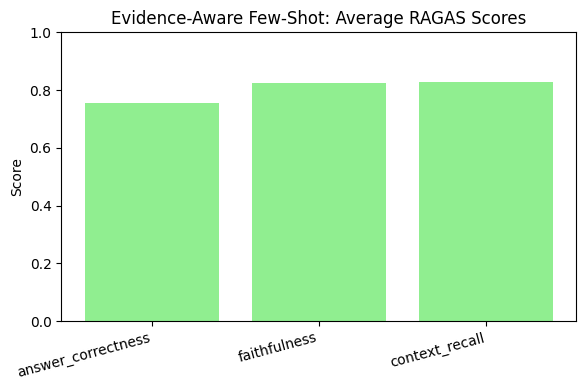

In [113]:
ev_fewshot_avg = df_ev_scores[
    ['answer_correctness', 'faithfulness', 'context_recall']
].mean().to_frame().T
ev_fewshot_avg.index = ['evidence-aware-fewshot']
ev_fewshot_avg = ev_fewshot_avg.round(3)


display(Markdown("### Average RAGAS Scores for Evidence‐Aware Few‐Shot"))
display(ev_fewshot_avg)


ev_summary = ev_fewshot_avg.T.reset_index()
ev_summary.columns = ['metric', 'score']


display(Markdown("### Evidence‐Aware Few‐Shot: Average RAGAS Scores"))
display(ev_summary)


plt.figure(figsize=(6, 4))
plt.bar(ev_summary['metric'], ev_summary['score'], color='lightgreen')
plt.title('Evidence‐Aware Few‐Shot: Average RAGAS Scores')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.show()

### Average RAGAS Scores by Prompting Strategy

answer_correctness  faithfulness  context_recall
Evidence-Aware Few-Shot                0.755         0.825           0.827
Evidence-Aware Zero-Shot               0.602         0.769           0.853

### Average RAGAS Scores: Few-Shot vs. Zero-Shot

strategy              metric  score
0   Evidence-Aware Few-Shot  answer_correctness  0.755
1  Evidence-Aware Zero-Shot  answer_correctness  0.602
2   Evidence-Aware Few-Shot        faithfulness  0.825
3  Evidence-Aware Zero-Shot        faithfulness  0.769
4   Evidence-Aware Few-Shot      context_recall  0.827
5  Evidence-Aware Zero-Shot      context_recall  0.853

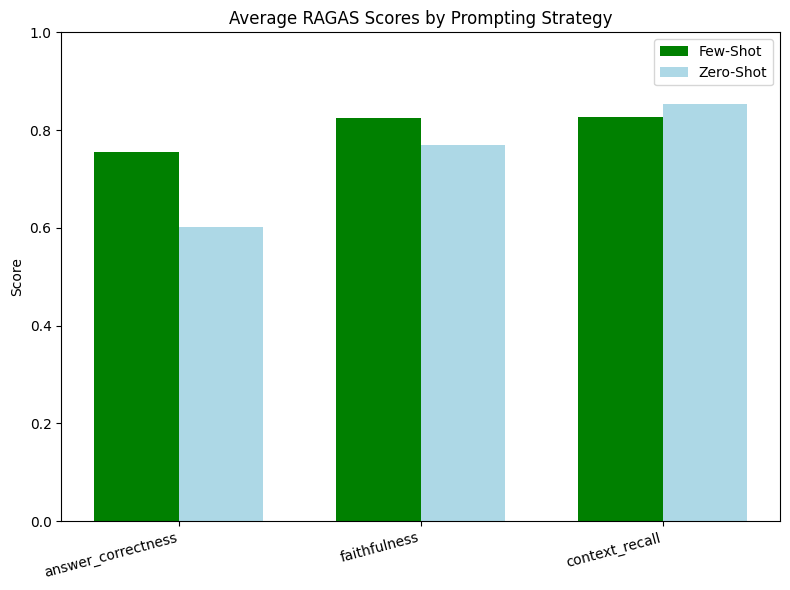

In [117]:

fewshot_avg = (
    df_ev_scores[['answer_correctness', 'faithfulness', 'context_recall']]
    .mean()
    .to_frame()
    .T
    .round(3)
)
fewshot_avg.index = ['Evidence-Aware Few-Shot']

zeroshot_avg = (
    df_ev_zero_scores[['answer_correctness', 'faithfulness', 'context_recall']]
    .mean()
    .to_frame()
    .T
    .round(3)
)
zeroshot_avg.index = ['Evidence-Aware Zero-Shot']


combined_avg = pd.concat([fewshot_avg, zeroshot_avg])
display(Markdown("### Average RAGAS Scores by Prompting Strategy"))
display(combined_avg)


combined_summary = (
    combined_avg
    .reset_index()
    .melt(
        id_vars='index',
        value_vars=['answer_correctness', 'faithfulness', 'context_recall'],
        var_name='metric',
        value_name='score'
    )
    .rename(columns={'index': 'strategy'})
)
display(Markdown("### Average RAGAS Scores: Few-Shot vs. Zero-Shot"))
display(combined_summary)


plt.figure(figsize=(8, 6))
import numpy as np

metrics   = combined_summary['metric'].unique()
x         = np.arange(len(metrics))
width     = 0.35


fs_scores = combined_summary.query("strategy=='Evidence-Aware Few-Shot'")['score']
zs_scores = combined_summary.query("strategy=='Evidence-Aware Zero-Shot'")['score']

plt.bar(x - width/2, fs_scores, width, label='Few-Shot', color='green')
plt.bar(x + width/2, zs_scores, width, label='Zero-Shot', color='lightblue')

plt.xticks(x, metrics, rotation=15, ha='right')
plt.ylim(0, 1)
plt.ylabel('Score')
plt.title('Average RAGAS Scores by Prompting Strategy')
plt.legend(title='')
plt.tight_layout()
plt.show()

#PoT Alt

In [43]:
import os
import json
import re
import traceback
from textwrap import dedent

import pandas as pd
from langchain.chat_models import ChatOpenAI
from langchain.schema import SystemMessage, HumanMessage


os.environ["OPENAI_API_KEY"]  = API_KEY
os.environ["OPENAI_API_BASE"] = API_ENDPOINT


chat = ChatOpenAI(
    openai_api_base=API_ENDPOINT,
    openai_api_key=API_KEY,
    model="gpt-4o-mini",
    temperature=0.1,
)


with open("Ground_truth_fin_22-24.json", "r", encoding="utf-8") as f:
    ground_truth = json.load(f)[:-1]

pot_results = []
for item in ground_truth:
    q = item["question"]


    retrieved = retriever.invoke(q)
    doc_list = [
        {
            "text":        d.page_content,
            "source_file": d.metadata.get("source_file", "?"),
            "page_num":    d.metadata.get("page_num", "?")
        }
        for d in retrieved
    ]


    prompt = [
    SystemMessage(content="You are a data analyst. Use only the provided docs."),
    HumanMessage(content="Docs JSON:\n" + json.dumps(doc_list, ensure_ascii=False)),
    HumanMessage(content=(
        f"Question: {q}\n\n"
        "Write a Python function `run(docs)` that:\n"
        "  1. Accepts `docs` (a list of dicts with keys `text`, `source_file`, `page_num`).\n"
        "  2. Examines the Question text to classify it as one of three types:\n"
        "       • **Change question**: contains two distinct period labels (e.g. “from A to B”).\n"
        "       • **Single‐period question**: mentions exactly one period label (e.g. “in 2021”).\n"
        "       • **Policy question**: contains keywords like “policy”, “regulation”, “strategy”, etc.\n"
        "  3. If it’s a **change question**:\n"
        "       a. Programmatically extract `period1`, `period2`, and `unit` from the question.\n"
        "       b. From `docs`, find numeric `value1` for `period1` and `value2` for `period2` (recording each `(source_file, page_num)`).\n"
        "       c. Compute `diff = value2 - value1` and `pct = diff / value1 * 100`.\n"
        "       d. Build `answer` exactly as:\n"
        "          \"<entity>’s <metric> increased from {value1:,} {unit} in {period1} to {value2:,} {unit} in {period2} — an increase of {diff:,} {unit} or approximately {pct:.1f}%.\"  \n"
        "  4. Elif it’s a **single‐period question**:\n"
        "       a. Extract `period` and `unit` from the question.\n"
        "       b. From `docs`, find numeric `value` for that period (record `(source_file, page_num)`).\n"
        "       c. Build `answer` as:\n"
        "          \"<entity>’s <metric> for {period} was {value:,} {unit}.\"\n"
        "  5. Elif it’s a **policy question**:\n"
        "       a. Search `docs` for the most relevant paragraphs discussing the policy.\n"
        "       b. Set `answer` to the concatenated plain‐text snippet(s) (no math).\n"
        "  6. Always record `sources` as a list of `(source_file, page_num)` where you found key info.\n"
        "  7. If you can’t find the needed data, set:\n"
        "       answer = \"I don't know\"\n"
        "       sources = []\n"
        "  8. Return `(answer, sources)`.\n\n"
        " Do **not** JSON‐load inside your function; assume `docs` is already a Python list.\n"
        "Wrap your code in a ```python … ``` fence."
    ))
]

    resp = chat.invoke(prompt)


    m = re.search(r"```python\n(.+?)```", resp.content, re.DOTALL)
    if not m:
        pot_code = None
        error = "No code block found"
        answer = None
        sources = []
    else:
        pot_code = dedent(m.group(1))
        # 3d. Exec & call, capturing any errors
        exec_globals = {}
        try:
            exec(pot_code, exec_globals)
            answer, sources = exec_globals["run"](doc_list)
            error = None
        except Exception as e:
            answer = None
            sources = []
            error = traceback.format_exc()


    pot_results.append({
        "question":           q,
        "prediction":         answer,
        "sources":            sources,
        "retrieved_contexts": [doc["text"] for doc in doc_list],  # <— add this
        "ground_truth":       str(item["ground_truth_answer"]),
        "pot_code":           pot_code,
        "error":              error,
    })

# 4. Build DataFrame
df = pd.DataFrame(pot_results)
print(df.head())
# Now you can inspect pot_code and error columns to debug
df.to_csv("pot_results_with_code_2.csv", index=False)



                                            question  \
0  How much fuel did Lufthansa save by shutting d...   
1  What is the carbon dioxide emissions for Lufth...   
2  By how many % did Fuel consumption, specific, ...   
3  How much SAF did KLM use in flight operations ...   
4  What were KLM’s Scope 3 emissions from Well-To...   

                                          prediction  \
0  Lufthansa’s fuel savings for 2024 was 2,750 to...   
1                                       I don't know   
2                                               None   
3          KLM’s SAF usage for 2024 was 2,024 Ktons.   
4                                               None   

                                             sources  \
0  [(Lufthansa Sustainability, 19), (Lufthansa Su...   
1                                                 []   
2                                                 []   
3                         [(KLM Sustainability, 42)]   
4                                             

In [39]:
df

question  \
0   How much fuel did Lufthansa save by shutting d...   
1   What is the carbon dioxide emissions for Lufth...   
2   By how many % did Fuel consumption, specific, ...   
3   How much SAF did KLM use in flight operations ...   
4   What were KLM’s Scope 3 emissions from Well-To...   
5   What key policies and initiatives does KLM out...   
6   Which regulatory framework does KLM refer to i...   
7   What policy mechanisms and national actions ar...   
8   By how much did KLM increase its use of Sustai...   
9   How much did Qantas's SAF usage increase from ...   
10  What was the average percentage increase in av...   
11  Which airline had a higher percentage increase...   
12  How did Emirates' carbon monoxide (CO) emissio...   
13  How do Emirates' and Lufthansa's carbon monoxi...   
14  What are the key policy and strategic measures...   
15  What operational policies and efficiency initi...   
16  What core principles define Lufthansa’s corpor...   
17  How does Lufthansa ensure that its environment...   
18  By how much did Qantas Group’s Scope 3 CO₂ emi...   
19  What was the average percentage increase in SA...   
20  By what percentage did KLM’s aviation fuel CO₂...   
21  How did KLM’s CO₂ savings from SAF change in 2...   
22  What were Lufthansa’s total CO₂ emissions in 2...   
23  What standard does Lufthansa apply to calculat...   

                                           prediction  \
0                                        I don't know   
1                                        I don't know   
2                                                None   
3           KLM’s SAF usage for 2024 was 2,024 Ktons.   
4                                                None   
5   Improve for the future The second strategic pi...   
6   ESG Statement The Corporate Sustainability Rep...   
7   In its most recent Federal Budget, the Governm...   
8   KLM’s SAF increased from 2,022 SAF in 2023 to ...   
9                                                None   
10                                               None   
11                                               None   
12                                       I don't know   
13                                       I don't know   
14  These policies have been consistently applied ...   
15                                       I don't know   
16  In April 2023, the CEO of Lufthansa Airlines, ...   
17  Environmental Statement 2024 Lufthansa Airline...   
18                                               None   
19                                               None   
20                                               None   
21                                               None   
22                                               None   
23  Lufthansa applies the DIN EN 16258 to calculat...   

                                              sources  \
0                                                  []   
1                                                  []   
2                                                  []   
3                          [(KLM Sustainability, 42)]   
4                                                  []   
5   [(KLM Sustainability, 39), (KLM Sustainability...   
6   [(KLM Sustainability, 29), (KLM Sustainability...   
7   [(Qantas Sustainability, 14), (Qantas Sustaibi...   
8   [(KLM 2022, 114), (KLM 2022, 57), (KLM Sustain...   
9                                                  []   
10                                                 []   
11                                                 []   
12                                                 []   
13                                                 []   
14  [(KLM 2022, 114), (KLM 2022, 94), (KLM 2022, 3...   
15                                                 []   
16                   [(Lufthansa Sustainability, 16)]   
17  [(Lufthansa Sustainability, 12), (Lufthansa Su...   
18                                                 []   
19                                                 []

In [36]:
# @title
import ast

def parse_list_literal(x):
    if isinstance(x, str):
        try:
            return ast.literal_eval(x)
        except Exception:

            return x
    else:

        return x


df['retrieved_contexts'] = df['retrieved_contexts'].apply(parse_list_literal)

In [45]:
# @title
print(df['retrieved_contexts'].apply(type).value_counts())

retrieved_contexts
<class 'list'>    24
Name: count, dtype: int64


In [46]:
from datasets import Dataset
from ragas import evaluate
from ragas.llms import LangchainLLMWrapper
from ragas.metrics import AnswerCorrectness, Faithfulness, LLMContextRecall
df_eval["sources"] = df_eval["sources"].apply(
    lambda lst: [{"source_file": f, "page_num": p} for f, p in lst]
)


ds = Dataset.from_pandas(df_eval, preserve_index=False)
df_eval = df_eval.rename(columns={
    "prediction": "answer",
    "ground_truth": "reference",
    "retrieved_contexts": "retrieved_contexts"
})

# Drop sources
ds = Dataset.from_pandas(df_eval.drop(columns=["sources"]), preserve_index=False)

# Build the dataset
dataset_eval = Dataset.from_pandas(df_eval, preserve_index=False)

# Evaluate
llm_wrapper = LangchainLLMWrapper(chat)
eval_results = evaluate(
    dataset_eval,
    metrics=[AnswerCorrectness(), Faithfulness(), LLMContextRecall()],
    llm=llm_wrapper
)

print(eval_results.to_pandas().round(3))

Evaluating:   0%|          | 0/72 [00:00<?, ?it/s]

ERROR:ragas.executor:Exception raised in Job[6]: KeyError('response')
ERROR:ragas.executor:Exception raised in Job[7]: KeyError('response')
ERROR:ragas.executor:Exception raised in Job[12]: KeyError('response')
ERROR:ragas.executor:Exception raised in Job[13]: KeyError('response')
ERROR:ragas.executor:Exception raised in Job[27]: KeyError('response')
ERROR:ragas.executor:Exception raised in Job[28]: KeyError('response')
ERROR:ragas.executor:Exception raised in Job[30]: KeyError('response')
ERROR:ragas.executor:Exception raised in Job[31]: KeyError('response')
ERROR:ragas.executor:Exception raised in Job[33]: KeyError('response')
ERROR:ragas.executor:Exception raised in Job[34]: KeyError('response')
ERROR:ragas.executor:Exception raised in Job[54]: KeyError('response')
ERROR:ragas.executor:Exception raised in Job[55]: KeyError('response')
ERROR:ragas.executor:Exception raised in Job[57]: KeyError('response')
ERROR:ragas.executor:Exception raised in Job[58]: KeyError('response')
ERROR:ra

                                           user_input  \
0   How much fuel did Lufthansa save by shutting d...   
1   What is the carbon dioxide emissions for Lufth...   
2   By how many % did Fuel consumption, specific, ...   
3   How much SAF did KLM use in flight operations ...   
4   What were KLM’s Scope 3 emissions from Well-To...   
5   What key policies and initiatives does KLM out...   
6   Which regulatory framework does KLM refer to i...   
7   What policy mechanisms and national actions ar...   
8   By how much did KLM increase its use of Sustai...   
9   How much did Qantas's SAF usage increase from ...   
10  What was the average percentage increase in av...   
11  Which airline had a higher percentage increase...   
12  How did Emirates' carbon monoxide (CO) emissio...   
13  How do Emirates' and Lufthansa's carbon monoxi...   
14  What are the key policy and strategic measures...   
15  What operational policies and efficiency initi...   
16  What core principles define

### Average RAGAS Scores for Program-of-Thought

answer_correctness  faithfulness  context_recall
program-of-thought               0.344         0.498           0.826

### Program-of-Thought: Average RAGAS Scores

metric  score
0  answer_correctness  0.344
1        faithfulness  0.498
2      context_recall  0.826

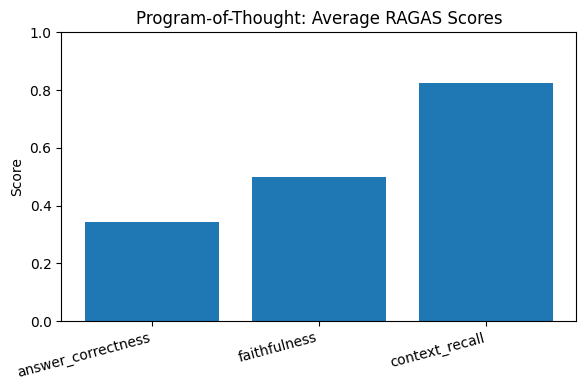

In [47]:
import matplotlib.pyplot as plt
from IPython.display import display, Markdown


df_scores = eval_results.to_pandas().round(3)


pot_avg = df_scores[
    ['answer_correctness', 'faithfulness', 'context_recall']
].mean().to_frame().T
pot_avg.index = ['program-of-thought']
pot_avg = pot_avg.round(3)


display(Markdown("### Average RAGAS Scores for Program-of-Thought"))
display(pot_avg)


pot_summary = pot_avg.T.reset_index()
pot_summary.columns = ['metric', 'score']


display(Markdown("### Program-of-Thought: Average RAGAS Scores"))
display(pot_summary)


plt.figure(figsize=(6, 4))
plt.bar(pot_summary['metric'], pot_summary['score'])
plt.title('Program-of-Thought: Average RAGAS Scores')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.show()

#Chain of Thought

In [48]:
import os
import json
from datasets import Dataset
from langchain.chat_models import ChatOpenAI
from langchain.schema import SystemMessage, HumanMessage
from ragas import evaluate
from ragas.llms import LangchainLLMWrapper
from ragas.metrics import FactualCorrectness, Faithfulness, LLMContextRecall
import pandas as pd


os.environ["OPENAI_API_KEY"] = API_KEY
os.environ["OPENAI_API_BASE"] = API_ENDPOINT


chat = ChatOpenAI(
    openai_api_base=API_ENDPOINT,
    openai_api_key=API_KEY,
    model="gpt-4o-mini",
    temperature=0.1,
)


with open("Ground_truth_fin_22-24.json", "r", encoding="utf-8") as f:
    ground_truth = json.load(f)


pot_results = []
for item in ground_truth:
    question = item["question"]


    retrieved_docs = retriever.invoke(question)
    doc_references = "\n\n".join(
        f"Title: {doc.metadata.get('source_file','Unknown')}\n"
        f"Page: {doc.metadata.get('page_num','?')}\n"
        f"{doc.page_content}"
        for doc in retrieved_docs
    )

    prompt = [
        SystemMessage(content=(
            "You are a document analyst. You will receive excerpts from sustainability reports of aviation companies.\n"
            "Use only this retrieved content to answer the question. If you can't find the answer, say \"I don't know\".\n"
            "At the end, list the sources you used with 'source_file' and 'page_num'."
        )),
        HumanMessage(content="Retrieved documents:\n\n" + doc_references),
        HumanMessage(content=(
            "Question: " + question + "\n\n"
            "Now, let's think through this step by step, citing passages as you go."
        ))
    ]

    resp = chat.invoke(prompt)

    pot_results.append({
        "model_id": "chain_of_thought",
        "question": question,
        "answer": resp.content,
        "reference": item["ground_truth_answer"],
        "contexts": [doc.page_content for doc in retrieved_docs]
    })


dataset_pot = Dataset.from_list(pot_results)
llm_wrapper = LangchainLLMWrapper(chat)




In [49]:
eval_pot = evaluate(
    dataset_pot,
    metrics=[AnswerCorrectness(), Faithfulness(), LLMContextRecall()],
    llm=llm_wrapper
)


df_cot_scores = eval_pot.to_pandas().round(3)
print("Chain-of-Thought Zero-Shot RAGAS Scores:")
print(df_cot_scores)


Evaluating:   0%|          | 0/75 [00:00<?, ?it/s]

Chain-of-Thought Zero-Shot RAGAS Scores:
                                           user_input  \
0   How much fuel did Lufthansa save by shutting d...   
1   What is the carbon dioxide emissions for Lufth...   
2   By how many % did Fuel consumption, specific, ...   
3   How much SAF did KLM use in flight operations ...   
4   What were KLM’s Scope 3 emissions from Well-To...   
5   What key policies and initiatives does KLM out...   
6   Which regulatory framework does KLM refer to i...   
7   What policy mechanisms and national actions ar...   
8   By how much did KLM increase its use of Sustai...   
9   How much did Qantas's SAF usage increase from ...   
10  What was the average percentage increase in av...   
11  Which airline had a higher percentage increase...   
12  How did Emirates' carbon monoxide (CO) emissio...   
13  How do Emirates' and Lufthansa's carbon monoxi...   
14  What are the key policy and strategic measures...   
15  What operational policies and efficiency in

In [60]:
import pandas as pd
from IPython.display import display, Markdown


pd.set_option('display.max_colwidth', None)


cot_df = df_cot_scores[['user_input', 'response', "reference" , "answer_correctness", "faithfulness"]]

display(Markdown("### Chain-of-Thought: All Q&A"))
display(cot_df)

### Chain-of-Thought: All Q&A

user_input  \
0                                                                    How much fuel did Lufthansa save by shutting down one engine during parking in 2024?   
1                                                                            What is the carbon dioxide emissions for Lufthansa in 2023 compared to 2022?   
2                                        By how many % did Fuel consumption, specific, passenger transport change for Lufthansa in 2023 compared to 2022?   
3                                                                                                  How much SAF did KLM use in flight operations in 2024?   
4                                                                            What were KLM’s Scope 3 emissions from Well-To-Wake flight ops fuel in 2024?   
5       What key policies and initiatives does KLM outline under its “Improve for the future” pillar to make flying cleaner, quieter, and more efficient?   
6                                                                         Which regulatory framework does KLM refer to in its 2024 sustainability report?   
7   What policy mechanisms and national actions are supporting the development of the sustainable aviation fuel (SAF) industry globally and in Australia?   
8                 By how much did KLM increase its use of Sustainable Aviation Fuel (SAF) in 2024 compared to 2023, and what was the percentage increase?   
9                                                     How much did Qantas's SAF usage increase from FY23 to FY24, both in litres and in percentage terms?   
10                                         What was the average percentage increase in aviation fuel consumption from 2023 to 2024 across Qantas and KLM?   
11                                           Which airline had a higher percentage increase in SAF usage between 2022–23 and 2023–24: Emirates or Qantas?   
12                                 How did Emirates' carbon monoxide (CO) emissions change from 2022–23 to 2023–24, and what was the percentage increase?   
13                                                How do Emirates' and Lufthansa's carbon monoxide (CO) emissions from flight operations compare in 2023?   
14           What are the key policy and strategic measures KLM is implementing to support the use of Sustainable Aviation Fuel (SAF) by 2025 and beyond?   
15           What operational policies and efficiency initiatives has Lufthansa implemented to reduce fuel consumption and CO₂ emissions as of 2023–2024?   
16                                                                     What core principles define Lufthansa’s corporate environmental policy as of 2024?   
17                                                          How does Lufthansa ensure that its environmental policy is implemented and adapted over time?   
18                                By how much did Qantas Group’s Scope 3 CO₂ emissions increase from FY23 to FY24, both in absolute and percentage terms?   
19                                                    What was the average percentage increase in SAF usage from 2023 to 2024 across both Qantas and KLM?   
20                                                              By what percentage did KLM’s aviation fuel CO₂ emissions change in 2022 compared to 2021?   
21                                                                                    How did KLM’s CO₂ savings from SAF change in 2022 compared to 2021?   
22                                                                   What were Lufthansa’s total CO₂ emissions in 2021, and how did this compare to 2020?   
23        What standard does Lufthansa apply to calculate its greenhouse gas emissions for transport processes, and since when has that standard existed?   
24                                 How much Sustainable Aviation Fuel (SAF) did Emirates use in 2021–22, and what was the percentage change from 2020–21?   

                                                            

### Average RAGAS Scores for Chain-of-Thought

answer_correctness  faithfulness  context_recall
Chain-of-thought                0.53          0.79           0.817

### Chain-of-Thought: Average RAGAS Scores

metric  score
0  answer_correctness  0.530
1        faithfulness  0.790
2      context_recall  0.817

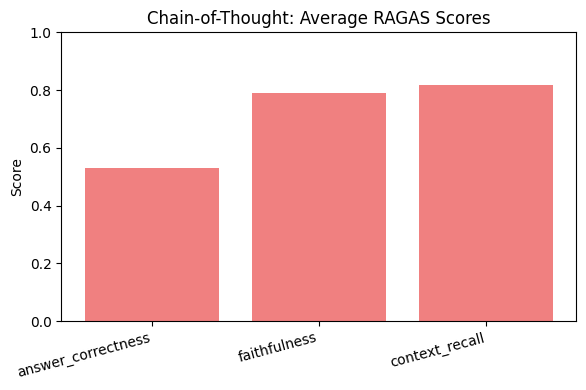

In [50]:
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

# 1. Compute mean scores for Program-of-Thought strategy
pot_avg = df_cot_scores[
    ['answer_correctness', 'faithfulness', 'context_recall']
].mean().to_frame().T
pot_avg.index = ['Chain-of-thought']
pot_avg = pot_avg.round(3)

# 2. Display wide-format summary
display(Markdown("### Average RAGAS Scores for Chain-of-Thought"))
display(pot_avg)

# 3. Prepare long-format summary for plotting
pot_summary = pot_avg.T.reset_index()
pot_summary.columns = ['metric', 'score']

# 4. Display long-format summary
display(Markdown("### Chain-of-Thought: Average RAGAS Scores"))
display(pot_summary)

# 5. Plot the bar chart
plt.figure(figsize=(6, 4))
plt.bar(pot_summary['metric'], pot_summary['score'], color='lightcoral')
plt.title('Chain-of-Thought: Average RAGAS Scores')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.show()

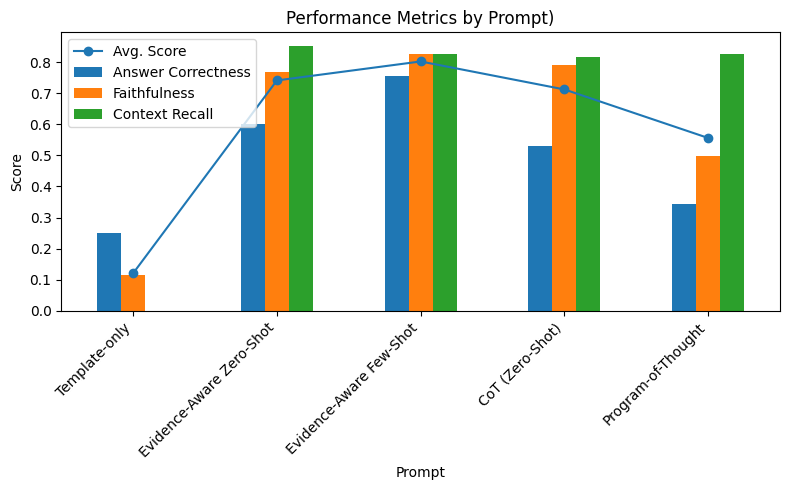

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
data = {
    'Prompt': [
        'Template-only',
        'Evidence-Aware Zero-Shot',
        'Evidence-Aware Few-Shot',
        'CoT (Zero-Shot)',
        'Program-of-Thought'
    ],
    'Answer Correctness': [0.25, 0.602, 0.755, 0.53, 0.344],
    'Faithfulness':         [0.114, 0.769, 0.825, 0.79, 0.498],
    'Context Recall':       [0.0,   0.853, 0.827, 0.817, 0.826],
    'Avg. Score':           [0.121, 0.741, 0.802, 0.712, 0.556]
}

df = pd.DataFrame(data)


metrics = ['Answer Correctness', 'Faithfulness', 'Context Recall']
ax = df.set_index('Prompt')[metrics].plot(kind='bar', figsize=(8,5))


x = range(len(df))
ax.plot(x, df['Avg. Score'], marker='o', linestyle='-', label='Avg. Score')


ax.set_xticks(x)
ax.set_xticklabels(df['Prompt'], rotation=45, ha='right')
ax.set_ylabel('Score')
ax.set_title('Performance Metrics by Prompt)')
ax.legend()
plt.tight_layout()
plt.show()

In [1]:
import pandas as pd


data = {
    'Prompt': [
        'Template-only',
        'Evidence-Aware Zero-Shot',
        'Evidence-Aware Few-Shot',
        'CoT (Zero-Shot)',
        'Program-of-Thought'
    ],
    'Answer Correctness': [0.25, 0.602, 0.755, 0.53, 0.344],
    'Faithfulness':         [0.114, 0.769, 0.825, 0.79, 0.498],
    'Context Recall':       [0.0,   0.853, 0.827, 0.817, 0.826],
    'Avg. Score':           [0.121, 0.741, 0.802, 0.712, 0.556]
}
df = pd.DataFrame(data).set_index('Prompt')


styled = (
    df.style
      .background_gradient(cmap='RdYlGn', axis=None)
      .format("{:.3f}")
)


styled